In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates

from sklearn.model_selection  import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold 
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
import lightgbm

from datetime import datetime





In [76]:
plt.style.use('seaborn-dark-palette')


In [38]:
df = pd.read_csv('all_data.csv')
y = df['beat_spread']
X = df.copy()
X.pop('beat_spread')
X.pop('date')
X.pop('Unnamed: 0')

model = LGBMClassifier(n_estimators = 50)
model.fit(X, y)

LGBMClassifier(n_estimators=50)

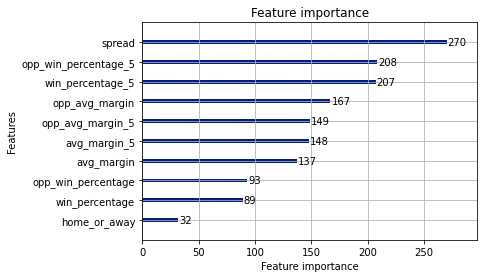

In [77]:
lightgbm.plot_importance(model)
plt.savefig('figures/feature_importance.png', bbox_inches='tight', format = 'png', dpi=800)

In [39]:
df_2022 = pd.read_csv('2022_data.csv')
dates_str = list(df_2022['date'])
datetime_str = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in dates_str]
df_2022.pop('date')
df_2022['date'] = datetime_str

df_2022 = df_2022.sort_values(by=['date'])

df_2022.pop('Unnamed: 0')

y_2022 = df_2022['beat_spread']
X_2022 = df_2022.copy()
date_order = X_2022['date']
X_2022.pop('date')
X_2022.pop('beat_spread')
X_2022.head()

,win_percentage_5,win_percentage,avg_margin_5,avg_margin,home_or_away,spread,opp_win_percentage_5,opp_win_percentage,opp_avg_margin_5,opp_avg_margin
706,1.0,1.0,7.0,7.0,0,3.5,0.0,0.0,7.0,7.0
108,1.0,1.0,23.0,23.0,1,-1.5,0.0,0.0,23.0,23.0
630,0.0,0.0,7.0,7.0,1,-3.5,1.0,1.0,7.0,7.0
997,0.0,0.0,23.0,23.0,0,1.5,1.0,1.0,23.0,23.0
258,1.0,1.0,11.0,11.0,1,-7.0,0.0,0.0,11.0,11.0


In [64]:
print(date_order)
date_order = pd.date_range(start='10/19/2021', end='4/20/2022', periods = 1108)
print(date_order)

DatetimeIndex([          '2021-10-19 00:00:00',
               '2021-10-19 03:58:15.840867992',
               '2021-10-19 07:56:31.681735985',
               '2021-10-19 11:54:47.522603978',
               '2021-10-19 15:53:03.363471971',
               '2021-10-19 19:51:19.204339963',
               '2021-10-19 23:49:35.045207956',
               '2021-10-20 03:47:50.886075949',
               '2021-10-20 07:46:06.726943942',
               '2021-10-20 11:44:22.567811934',
               ...
               '2022-04-18 12:15:37.432188066',
               '2022-04-18 16:13:53.273056058',
               '2022-04-18 20:12:09.113924052',
               '2022-04-19 00:10:24.954792044',
               '2022-04-19 04:08:40.795660038',
               '2022-04-19 08:06:56.636528030',
               '2022-04-19 12:05:12.477396022',
               '2022-04-19 16:03:28.318264016',
               '2022-04-19 20:01:44.159132008',
                         '2022-04-20 00:00:00'],
              dtype=

In [67]:

def season_simulator(bet_size, threshold, plot = True):
    db_size = X_2022.shape[0]

    if threshold<0.5:
        threshold = 0.5
    money = 100
    num_failed_bets = 100/bet_size
    money_series = []
    num_bets_made = 0
    correct_bets = 0
    total_games = 0
    for i in range(db_size):
        if money>bet_size:
            sample = np.array(X_2022.iloc[i])
            prediction = model.predict(sample.reshape(1,-1))
            model_certainty = model.predict_proba(sample.reshape(1,-1))
            actual = y_2022.iloc[i]

            if abs(model_certainty[0][0]-0.5)>abs(threshold-0.5):
                num_bets_made+=1
                if prediction == actual:
                    money+=bet_size/1.1
                    correct_bets+=1
                else:
                    money-=bet_size
        total_games+=1

        money_series.append(money)

    if num_bets_made == 0:
        accuracy = 0
    else:
        accuracy = correct_bets/num_bets_made
    
    description = 'accuracy of bets: ' + '{:.2f}'.format(100*accuracy)+'%\npercent of games bet on: '+'{:.2f}'.format(100*num_bets_made/total_games)+'%'
    money_made = '\nmoney made: $'+'{:.2f}'.format(money)
    legend_text = description+money_made
    if plot:
        dates_plt = matplotlib.dates.date2num(date_order)

        fig, ax = plt.subplots()
        plt.plot(date_order, money_series, label = legend_text)
        plt.plot(date_order, [100]*len(date_order), label = 'starting money')
        myFmt = matplotlib.dates.DateFormatter("%b")
        ax.xaxis.set_major_formatter(myFmt)
        ax.set_title('Full Season Simulation\nBet $90 on games with '+'{:.0f}'.format(100*threshold)+'% confidence')
        #ax.suptitle('Bet on games with '+'{:.2f}'.format(100*threshold)+' confidence')
        
        ax.legend()
        
        fig.autofmt_xdate()
        plt.savefig('figures/season_simulated.png', format="png", dpi=1200)
        plt.show()
    
    return money

In [41]:

thresholds = np.linspace(0.5, 0.95, 10)
money_made = {}

betsizes = np.linspace(10,100,10)
num_failed_bets = 100/betsizes

all = []
for num_failed_bet in num_failed_bets:
    mini = []
    for threshold in thresholds:
        money = season_simulator(100/num_failed_bet,threshold, False)
        print('Bet Size: {0}, Certainty Threshold {1}, Money Made: {2}'.format(100/num_failed_bet, threshold, money))
        money_made[(num_failed_bet, threshold)] = money
        mini.append(money)
    all.append(mini)
data = np.array(all)


Bet Size: 10.0, Certainty Threshold 0.5, Money Made: 4197.272727272676
Bet Size: 10.0, Certainty Threshold 0.55, Money Made: 4229.9999999999545
Bet Size: 10.0, Certainty Threshold 0.6, Money Made: 3909.999999999961
Bet Size: 10.0, Certainty Threshold 0.65, Money Made: 3639.999999999968
Bet Size: 10.0, Certainty Threshold 0.7, Money Made: 3142.7272727272475
Bet Size: 10.0, Certainty Threshold 0.75, Money Made: 2619.9999999999823
Bet Size: 10.0, Certainty Threshold 0.8, Money Made: 1963.6363636363549
Bet Size: 10.0, Certainty Threshold 0.85, Money Made: 1249.0909090909083
Bet Size: 10.0, Certainty Threshold 0.8999999999999999, Money Made: 679.9999999999999
Bet Size: 10.0, Certainty Threshold 0.95, Money Made: 472.7272727272722
Bet Size: 20.0, Certainty Threshold 0.5, Money Made: 8294.545454545354
Bet Size: 20.0, Certainty Threshold 0.55, Money Made: 8359.999999999909
Bet Size: 20.0, Certainty Threshold 0.6, Money Made: 7719.999999999923
Bet Size: 20.0, Certainty Threshold 0.65, Money Mad

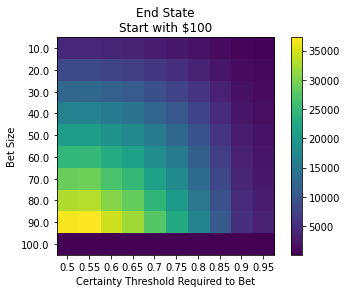

In [78]:
import seaborn as sns
fig, ax = plt.subplots()
im = ax.imshow(data, cmap = 'viridis')
ax.set_xticks(np.arange(len(thresholds)), labels=[round(threshold, 2) for threshold in thresholds])
ax.set_yticks(np.arange(len(betsizes)), labels=betsizes)
ax.set_xlabel('Certainty Threshold Required to Bet')
ax.set_ylabel('Bet Size')
ax.set_title('End State\nStart with $100')
#ax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im)
plt.savefig('figures/money_matrix.png', format = 'png', dpi=1200)

In [49]:
print(data)
print(thresholds)
print(betsizes)

[[ 4197.27272727  4230.          3910.          3640.
   3142.72727273  2620.          1963.63636364  1249.09090909
    680.           472.72727273]
 [ 8294.54545455  8360.          7720.          7180.
   6185.45454545  5140.          3827.27272727  2398.18181818
   1260.           845.45454545]
 [12391.81818182 12490.         11530.         10720.
   9228.18181818  7660.          5690.90909091  3547.27272727
   1840.          1218.18181818]
 [16489.09090909 16620.         15340.         14260.
  12270.90909091 10180.          7554.54545455  4696.36363636
   2420.          1590.90909091]
 [20586.36363636 20750.         19150.         17800.
  15313.63636364 12700.          9418.18181818  5845.45454545
   3000.          1963.63636364]
 [24683.63636364 24880.         22960.         21340.
  18356.36363636 15220.         11281.81818182  6994.54545455
   3580.          2336.36363636]
 [28780.90909091 29010.         26770.         24880.
  21399.09090909 17740.         13145.45454545  8143

In [54]:
most_money = max(money_made, key = money_made.get)
maxed_money = money_made[most_money]
print('max amount of money to make is ', maxed_money)
print('model confidence: ', most_money[1])
print('max number of failed bets: ', most_money[0])

max amount of money to make is  37269.99999999972
model confidence:  0.55
max number of failed bets:  1.1111111111111112


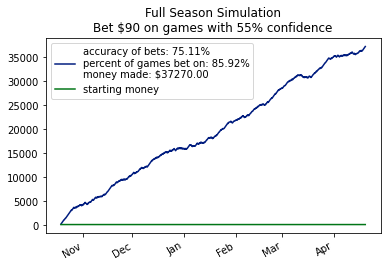

37269.99999999972

In [79]:
season_simulator(90, 0.55)

# Final Results

We have derived at optimal betting strategy for the 2022 Season.

Our model is accurate enough to bet on 92.87% of all games, betting for the side it has 53% confidence for. The model has a 73.47% accuracy. If the model starts with 100 bucks and bets 50 bucks each time, it can reach profits of $20,813.64 without ever going negative. It's essentially a money printing algorithm.